# introduction
This file is used to train an image segmentation model to detect plant diseases in order to be used in an application to detect plant health in real-time and classify what type of disease is it inflicted with if any.

## Dataset used
The dataset used is the PlantVillage Dataset from Kaggle. The dataset can be found [here](https://www.kaggle.com/datasets/alexisbcook/plantvillage).

# 1. Dataset
In this section, we will create:
1. the Dataset class.
2. the DataLoader class.

And we will explore the dataset and visualize each class size in training, validation and test sets.

In [3]:
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
import tqdm
import cv2

## 1.1. Creating a transformation pipeline
The pipeline consists of the following transformations:
1. Resize.
2. RandomCrop.
3. Rotate limit of 40 degrees.
4. HorizontalFlip.
5. VerticalFlip.
6. RGBShift.
7. OneOf: Blur or ColorJitter.
8. Normalize the images.
9. Converting to tensor via ToTensorV2.

In [4]:
# Creating a transformation pipeline using Albumentations
transform = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.1),
    A.RandomRotate90(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.GaussNoise(p=0.1),
    A.ShiftScaleRotate(
        shift_limit=0.05, scale_limit=0.1, rotate_limit=25,
        p=0.3, border_mode=0
    ),
    A.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
        max_pixel_value=255.0,
    ),
    ToTensorV2(),
], additional_targets={'mask': 'mask'})

c:\Users\basel\anaconda3\Lib\site-packages\albumentations\core\validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


## 1.2. Dataset Class & DataLoaders for the Dataset

In [5]:
import os
from pathlib import Path

In [6]:
class PlantVillageSegmentationClassificationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None, num_classes=15):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.num_classes = num_classes
        
        # Get all image paths and extract class labels from directory structure
        self.image_paths = sorted(list(Path(image_dir).rglob("*.jpg")))
        self.mask_paths = []
        self.labels = []
        valid_image_paths = []
        
        print(f"Found {len(self.image_paths)} images, checking for corresponding masks and extracting labels...")
        
        # Create class mapping from directory names
        self.class_to_idx = {}
        class_dirs = sorted([d for d in Path(image_dir).iterdir() if d.is_dir()])
        for idx, class_dir in enumerate(class_dirs):
            self.class_to_idx[class_dir.name] = idx
        
        print(f"Found {len(self.class_to_idx)} classes: {list(self.class_to_idx.keys())}")
        
        for img_path in self.image_paths:
            # Get class from parent directory name
            class_name = img_path.parent.name
            if class_name in self.class_to_idx:
                label = self.class_to_idx[class_name]
                
                # Build corresponding mask path
                rel_path = img_path.relative_to(image_dir)
                mask_path = Path(mask_dir) / rel_path.parent / f"{img_path.stem}_final_masked.jpg"
                
                if mask_path.exists():
                    self.mask_paths.append(mask_path)
                    self.labels.append(label)
                    valid_image_paths.append(img_path)
                else:
                    print(f"Mask missing for: {img_path}")
            else:
                print(f"Unknown class for: {img_path}")
        
        self.image_paths = valid_image_paths
        print(f"Final dataset size: {len(self.image_paths)} images with masks and labels")
        print(f"Class distribution: {np.bincount(self.labels)}")
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        image = np.array(Image.open(self.image_paths[idx]).convert("RGB"))
        mask = np.array(Image.open(self.mask_paths[idx]).convert("L"))
        label = self.labels[idx]
        
        if self.transform:
            transformed = self.transform(image=image, mask=mask)
            image = transformed["image"]
            mask = transformed["mask"]
        
        mask = (mask > 0).float()
        label = torch.tensor(label, dtype=torch.long)
        
        return image, mask, label  # Now returns image, mask, AND class label

- Adding the dataset file locations

In [7]:
dataset_loc = "G:\Work Projects\AI & ML Projects\Plants-Disease-Detection---Identification\data"
color_full_images_dir = "G:\Work Projects\AI & ML Projects\Plants-Disease-Detection---Identification\data\color"
segmented_images_dir = "G:\Work Projects\AI & ML Projects\Plants-Disease-Detection---Identification\data\segmented"

In [8]:
# Add class instances of Train, Validation, Test split datasets
train_dataset = PlantVillageSegmentationClassificationDataset(
    image_dir=os.path.join(color_full_images_dir, 'train'),
    mask_dir=os.path.join(segmented_images_dir, 'train'),
    transform=transform
)

val_dataset = PlantVillageSegmentationClassificationDataset(
    image_dir=os.path.join(color_full_images_dir, 'valid'),
    mask_dir=os.path.join(segmented_images_dir, 'valid'),
    transform=transform
)

test_dataset = PlantVillageSegmentationClassificationDataset(
    image_dir=os.path.join(color_full_images_dir, 'test'),
    mask_dir=os.path.join(segmented_images_dir, 'test'),
    transform=transform
)

# Testing for image size
print(f"Train Dataset Size: {len(train_dataset)}")
print(f"Validation Dataset Size: {len(val_dataset)}")
print(f"Test Dataset Size: {len(test_dataset)}")

Found 42473 images, checking for corresponding masks and extracting labels...
Found 38 classes: ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___healthy', 'Corn_(maize)___Northern_Leaf_Blight', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___healthy', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___healthy', 'Potato___Late_blight', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___healthy', 'Strawberry___Leaf_scorch', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___healthy', 'Tomato___Late_blight', 'Toma

In [9]:
# Building DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=0)

Batch - Images: torch.Size([16, 3, 256, 256]), Masks: torch.Size([16, 256, 256]), Labels: torch.Size([16])


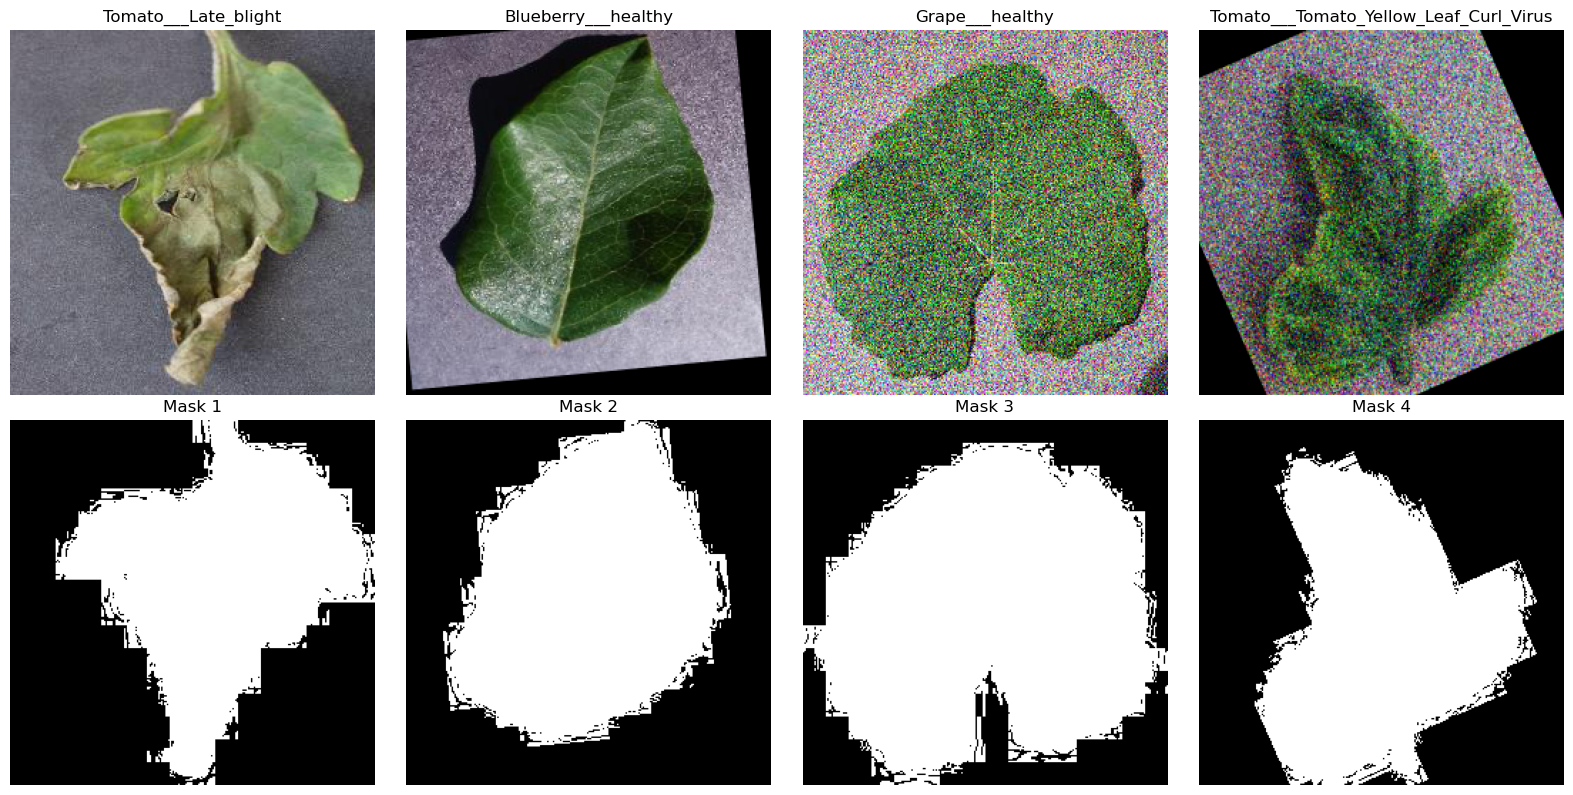

In [10]:
# Function to visualize a batch of images and masks
def visualize_batch(images, masks, labels, num_samples=4):
    fig, axes = plt.subplots(2, num_samples, figsize=(16, 8))
    
    # Denormalization parameters (from your Albumentations transform)
    mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1)
    
    # Denormalize images
    images_denorm = images * std + mean
    images_denorm = torch.clamp(images_denorm, 0, 1)

    # Get Image class names
    label_idx = labels[:num_samples].tolist()
    class_names = [key for key, value in train_dataset.class_to_idx.items()]
    
    for i in range(num_samples):
        # Display image
        axes[0, i].imshow(images_denorm[i].permute(1, 2, 0))
        axes[0, i].set_title(f'{class_names[label_idx[i]]}')
        axes[0, i].axis('off')
        
        # Display mask
        axes[1, i].imshow(masks[i].squeeze(), cmap='gray')
        axes[1, i].set_title(f'Mask {i+1}')
        axes[1, i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Test it with your data loader
for images, masks, labels in train_loader:
    print(f"Batch - Images: {images.shape}, Masks: {masks.shape}, Labels: {labels.shape}")
    visualize_batch(images, masks, labels)
    break

## 2. Model Building
In this second main section, we will build the Image Segmentation model (U-net) first, then build the classification model (ResNet18) and finally combine them together to form a complete model that segments the image first, then classifies it depending on all the classes present in the dataset.

In [11]:
import torch
import torch.nn as nn

from torchsummary import summary

from torch.optim import Adam, AdamW, SGD

## 2.1. Building the Image Segmentation Model (U-net)

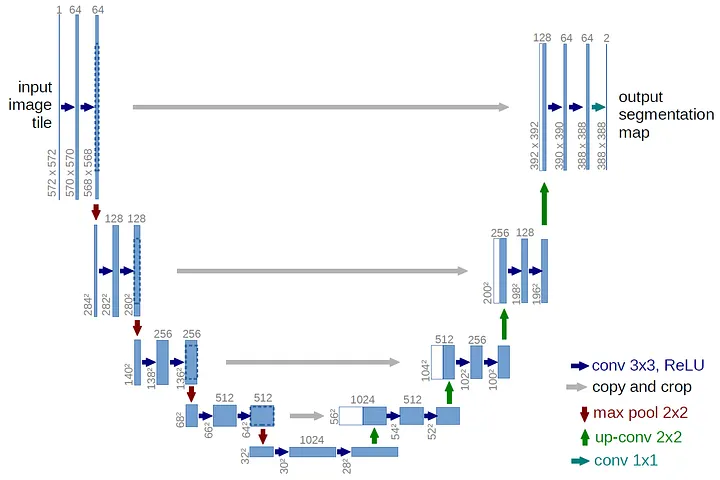

In [12]:
# Double-conv block
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

In [13]:
# Downsampling block
class DownSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = DoubleConv(in_channels, out_channels)
        self.pool = nn.MaxPool2d(2)

    def forward(self, x):
        x_conv = self.conv(x)
        x_pool = self.pool(x_conv)
        return x_conv, x_pool

In [14]:
# Upsampling block
class UpSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels//2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)
    
    def forward(self, x1, x2):
        x1 = self.up(x1)
        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x

In [15]:
# The U-Net model
class Unet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()

        # Encoder blocks (downsampling phase)
        self.down1 = DownSample(in_channels, 64)
        self.down2 = DownSample(64, 128)
        self.down3 = DownSample(128, 256)
        self.down4 = DownSample(256, 512)

        # Middle Phase (Bottleneck)
        self.middle = DoubleConv(512, 1024)

        # Upsample phase
        self.up1 = UpSample(1024, 512)
        self.up2 = UpSample(512, 256)
        self.up3 = UpSample(256, 128)
        self.up4 = UpSample(128, 64)
        
        # Output layer
        self.out = nn.Conv2d(64, num_classes, kernel_size=1)
    
    def forward(self, x):
        down_1, p1 = self.down1(x)
        down_2, p2 = self.down2(p1)
        down_3, p3 = self.down3(p2)
        down_4, p4 = self.down4(p3)
        middle = self.middle(p4)
        up_1 = self.up1(middle, down_4)
        up_2 = self.up2(up_1, down_3)
        up_3 = self.up3(up_2, down_2)
        up_4 = self.up4(up_3, down_1)
        out = self.out(up_4)
        return torch.sigmoid(out)

In [21]:
# Intialize the U-Net Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
segm_model = Unet(3, 1).to(device)

# Print the model summary
print(f"Model Device: {device}")
print("Model Summary:")
print(summary(segm_model, (3, 256, 256)))

Model Device: cuda
Model Summary:
Layer (type:depth-idx)                   Output Shape              Param #
├─DownSample: 1-1                        [-1, 64, 256, 256]        --
|    └─DoubleConv: 2-1                   [-1, 64, 256, 256]        --
|    |    └─Sequential: 3-1              [-1, 64, 256, 256]        38,976
|    └─MaxPool2d: 2-2                    [-1, 64, 128, 128]        --
├─DownSample: 1-2                        [-1, 128, 128, 128]       --
|    └─DoubleConv: 2-3                   [-1, 128, 128, 128]       --
|    |    └─Sequential: 3-2              [-1, 128, 128, 128]       221,952
|    └─MaxPool2d: 2-4                    [-1, 128, 64, 64]         --
├─DownSample: 1-3                        [-1, 256, 64, 64]         --
|    └─DoubleConv: 2-5                   [-1, 256, 64, 64]         --
|    |    └─Sequential: 3-3              [-1, 256, 64, 64]         886,272
|    └─MaxPool2d: 2-6                    [-1, 256, 32, 32]         --
├─DownSample: 1-4                    

## 2.2. Initializing the Image Segmentation Model
This section will contain initializing the modeland getting it ready for training.
We will create:
1. Custom DiceLoss function
2. Custom BCEWithDiceLoss function
3. Learning rate and Criterion for the model.
4. Early Stopping Criteria for the model.

In [16]:
# Implement BCEWithDiceLoss class
class BCEWithDiceLoss(nn.Module):
    def __init__(self):
        super(BCEWithDiceLoss, self).__init__()
        self.criterion = nn.BCEWithLogitsLoss()
        self.dice_loss = DiceLoss()
    
    def forward(self, input, target):
        # Ensure target has the same shape as input
        if len(target.shape) == 3:  # [batch, H, W]
            target = target.unsqueeze(1)  # Add channel dimension -> [batch, 1, H, W]
        
        bce_loss = self.criterion(input, target)
        dice_loss = self.dice_loss(input, target)
        bce_dice_loss = bce_loss + dice_loss
        return bce_dice_loss

# Add DiceLoss class
class DiceLoss(nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()
        
    def forward(self, input, target):
        smooth = 1.0
        
        # Ensure both have same shape
        if len(target.shape) == 3:
            target = target.unsqueeze(1)
        
        iflat = input.contiguous().view(-1)
        tflat = target.contiguous().view(-1)
        intersection = (iflat * tflat).sum()
        dice_loss = 1 - ((2.0 * intersection + smooth) / (iflat.sum() + tflat.sum() + smooth))
        return dice_loss

In [17]:
# Custom Early Stopping
class EarlyStopping:
    def __init__(self, patience=7, verbose=True, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = float('inf')
        self.delta = delta

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'checkpoint.pth')
        self.val_loss_min = val_loss

## 2.3. Training the Image Segmentation Model

In [18]:
import tqdm

In [18]:
# Implement Training loop - COMPLETE FIXED VERSION
def train(model_checkpoint_path, epochs, train_loader, val_loader=None, lr=0.0001, save_path='checkpoint_segm.pth', early_stopping_patience=7, early_stopping_delta=0.0001):
    """
    This function implements the training loop for the segmentation model.
    Inputs:
        1. model_checkpoint_path: Path to the model checkpoint file.
        2. epochs: Number of epochs to train the model.
        3. train_loader: Dataloader for the training dataset.
        4. val_loader: Dataloader for the validation dataset (optional).
        5. lr: Learning rate for the optimizer.
        6. save_path: Path to save the trained model.
        7. early_stopping_patience: Patience for early stopping.
        8. early_stopping_delta: Delta for early stopping.
    """
    # Early Stopping
    early_stopping = EarlyStopping(patience=early_stopping_patience, verbose=True, delta=early_stopping_delta)
    
    # Load model
    if model_checkpoint_path and os.path.exists(model_checkpoint_path):
        segm_model.load_state_dict(torch.load(model_checkpoint_path))
        print(f"Loaded model checkpoint from {model_checkpoint_path}")
    else:
        print("No model checkpoint provided. Training from scratch.")
    
    # Criterion + Optimizer
    criterion = BCEWithDiceLoss()
    optimizer = torch.optim.AdamW(segm_model.parameters(), lr=lr, weight_decay=1e-4)
    
    # Learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)
    
    # Mixed precision scaler
    scaler = torch.cuda.amp.GradScaler()
    
    # Training history
    train_losses = []
    val_losses = []
    
    print("Starting training with mixed precision...")
    print(f"Training on: {device}")
    print(f"Training samples: {len(train_loader.dataset)}")
    if val_loader:
        print(f"Validation samples: {len(val_loader.dataset)}")
    
    # Training loop
    for epoch in range(epochs):
        # Training phase
        segm_model.train()
        train_loss = 0.0
        
        # Progress bar for training
        train_pbar = tqdm.tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs} [Train]')
        
        for images, masks, labels in train_pbar:
            images = images.to(device)
            masks = masks.to(device)
            
            # Ensure masks have channel dimension
            if len(masks.shape) == 3:
                masks = masks.unsqueeze(1)
            
            optimizer.zero_grad()
            
            # Mixed precision forward pass
            with torch.cuda.amp.autocast():
                outputs = segm_model(images)
                loss = criterion(outputs, masks)
            
            # Mixed precision backward pass
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
            train_loss += loss.item()
            train_pbar.set_postfix({'Loss': f'{loss.item():.4f}'})
        
        avg_train_loss = train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        # Validation phase
        if val_loader is not None:
            segm_model.eval()
            val_loss = 0.0
            
            val_pbar = tqdm.tqdm(val_loader, desc=f'Epoch {epoch+1}/{epochs} [Val]')
            
            with torch.no_grad():
                for images, masks, labels in val_pbar:
                    images = images.to(device)
                    masks = masks.to(device)
                    
                    if len(masks.shape) == 3:
                        masks = masks.unsqueeze(1)
                    
                    # Mixed precision for validation too
                    with torch.cuda.amp.autocast():
                        outputs = segm_model(images)
                        loss = criterion(outputs, masks)
                    
                    val_loss += loss.item()
                    val_pbar.set_postfix({'Loss': f'{loss.item():.4f}'})
            
            avg_val_loss = val_loss / len(val_loader)
            val_losses.append(avg_val_loss)
            
            scheduler.step(avg_val_loss)
            current_lr = optimizer.param_groups[0]['lr']
            print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, LR: {current_lr:.6f}")
            
            early_stopping(avg_val_loss, segm_model)
        else:
            current_lr = optimizer.param_groups[0]['lr']
            print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.4f}, LR: {current_lr:.6f}")
            early_stopping(avg_train_loss, segm_model)
        
        if early_stopping.early_stop:
            print("Early stopping triggered.")
            break
        
        if (epoch + 1) % 10 == 0:
            checkpoint_path = f"{save_path}_epoch_{epoch+1}.pth"
            torch.save(segm_model.state_dict(), checkpoint_path)
            print(f"Model checkpoint saved: {checkpoint_path}")
    
    final_path = f"{save_path}_final.pth"
    torch.save(segm_model.state_dict(), final_path)
    print(f"Training complete. Final model saved: {final_path}")
    
    # Plot training history
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss', marker='o')
    if val_loader is not None:
        plt.plot(val_losses, label='Validation Loss', marker='s')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training History')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return train_losses, val_losses if val_loader is not None else None

No model checkpoint provided. Training from scratch.


C:\Users\basel\AppData\Local\Temp\ipykernel_26804\1448097582.py:33: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


Starting training with mixed precision...
Training on: cuda
Training samples: 42473
Validation samples: 5296


Epoch 1/10 [Train]:   0%|          | 0/2655 [00:00<?, ?it/s]C:\Users\basel\AppData\Local\Temp\ipykernel_26804\1448097582.py:65: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1/10 [Val]:   0%|          | 0/331 [00:00<?, ?it/s]C:\Users\basel\AppData\Local\Temp\ipykernel_26804\1448097582.py:96: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1/10 [Val]: 100%|██████████| 331/331 [02:23<00:00,  2.30it/s, Loss=0.5837]


Epoch [1/10], Train Loss: 0.5765, Val Loss: 0.5426, LR: 0.000100
Validation loss decreased (inf --> 0.542551).  Saving model ...


Epoch 2/10 [Val]: 100%|██████████| 331/331 [00:56<00:00,  5.87it/s, Loss=0.5780]


Epoch [2/10], Train Loss: 0.5401, Val Loss: 0.5367, LR: 0.000100
Validation loss decreased (0.542551 --> 0.536696).  Saving model ...


Epoch 3/10 [Val]: 100%|██████████| 331/331 [00:55<00:00,  6.00it/s, Loss=0.5732]


Epoch [3/10], Train Loss: 0.5365, Val Loss: 0.5360, LR: 0.000100
EarlyStopping counter: 1 out of 10


Epoch 4/10 [Val]: 100%|██████████| 331/331 [02:15<00:00,  2.44it/s, Loss=0.5761]


Epoch [4/10], Train Loss: 0.5349, Val Loss: 0.5334, LR: 0.000100
Validation loss decreased (0.536696 --> 0.533435).  Saving model ...


Epoch 5/10 [Val]: 100%|██████████| 331/331 [01:00<00:00,  5.43it/s, Loss=0.5767]


Epoch [5/10], Train Loss: 0.5342, Val Loss: 0.5333, LR: 0.000100
EarlyStopping counter: 1 out of 10


Epoch 6/10 [Val]: 100%|██████████| 331/331 [00:56<00:00,  5.82it/s, Loss=0.5707]


Epoch [6/10], Train Loss: 0.5333, Val Loss: 0.5332, LR: 0.000100
EarlyStopping counter: 2 out of 10


Epoch 7/10 [Val]: 100%|██████████| 331/331 [00:54<00:00,  6.04it/s, Loss=0.5722]


Epoch [7/10], Train Loss: 0.5327, Val Loss: 0.5324, LR: 0.000100
Validation loss decreased (0.533435 --> 0.532414).  Saving model ...


Epoch 8/10 [Val]: 100%|██████████| 331/331 [00:58<00:00,  5.68it/s, Loss=0.5726]


Epoch [8/10], Train Loss: 0.5322, Val Loss: 0.5316, LR: 0.000100
EarlyStopping counter: 1 out of 10


Epoch 9/10 [Val]: 100%|██████████| 331/331 [00:59<00:00,  5.52it/s, Loss=0.5748]


Epoch [9/10], Train Loss: 0.5319, Val Loss: 0.5326, LR: 0.000100
EarlyStopping counter: 2 out of 10


Epoch 10/10 [Val]: 100%|██████████| 331/331 [00:54<00:00,  6.08it/s, Loss=0.5722]


Epoch [10/10], Train Loss: 0.5316, Val Loss: 0.5315, LR: 0.000100
EarlyStopping counter: 3 out of 10
Model checkpoint saved: plant_segmentation_model_epoch_10.pth
Training complete. Final model saved: plant_segmentation_model_final.pth


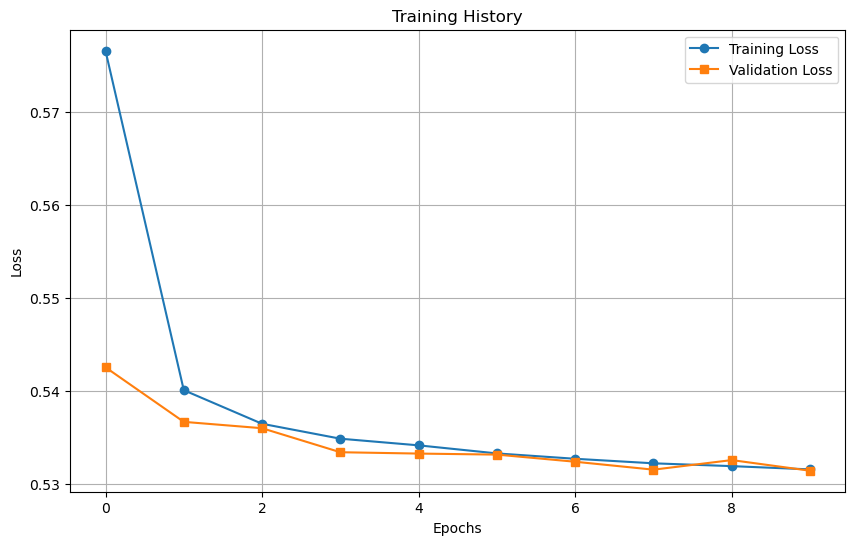

In [19]:
# Clear GPU cache
torch.cuda.empty_cache()

train_losses, val_losses = train(
    model_checkpoint_path=None,
    epochs=10,
    train_loader=train_loader,
    val_loader=val_loader, 
    lr=0.0001,
    save_path='plant_segmentation_model',
    early_stopping_patience=10,
    early_stopping_delta=0.001
)

# 3. Model Evaluation
In this section, we will evaluate all the versions of the models we built to see if they are performing well on the test set.

- Base start model:
1. Epochs = 10
2. LR = 0.0001
3. Batch size = 16
4. optimizer = AdamW
5. scheduler = ReduceLROnPlateau (Not activated)

## 3.1. Evaluation for Base Start Model

### 3.1.1. Testing model and visualizing outputs

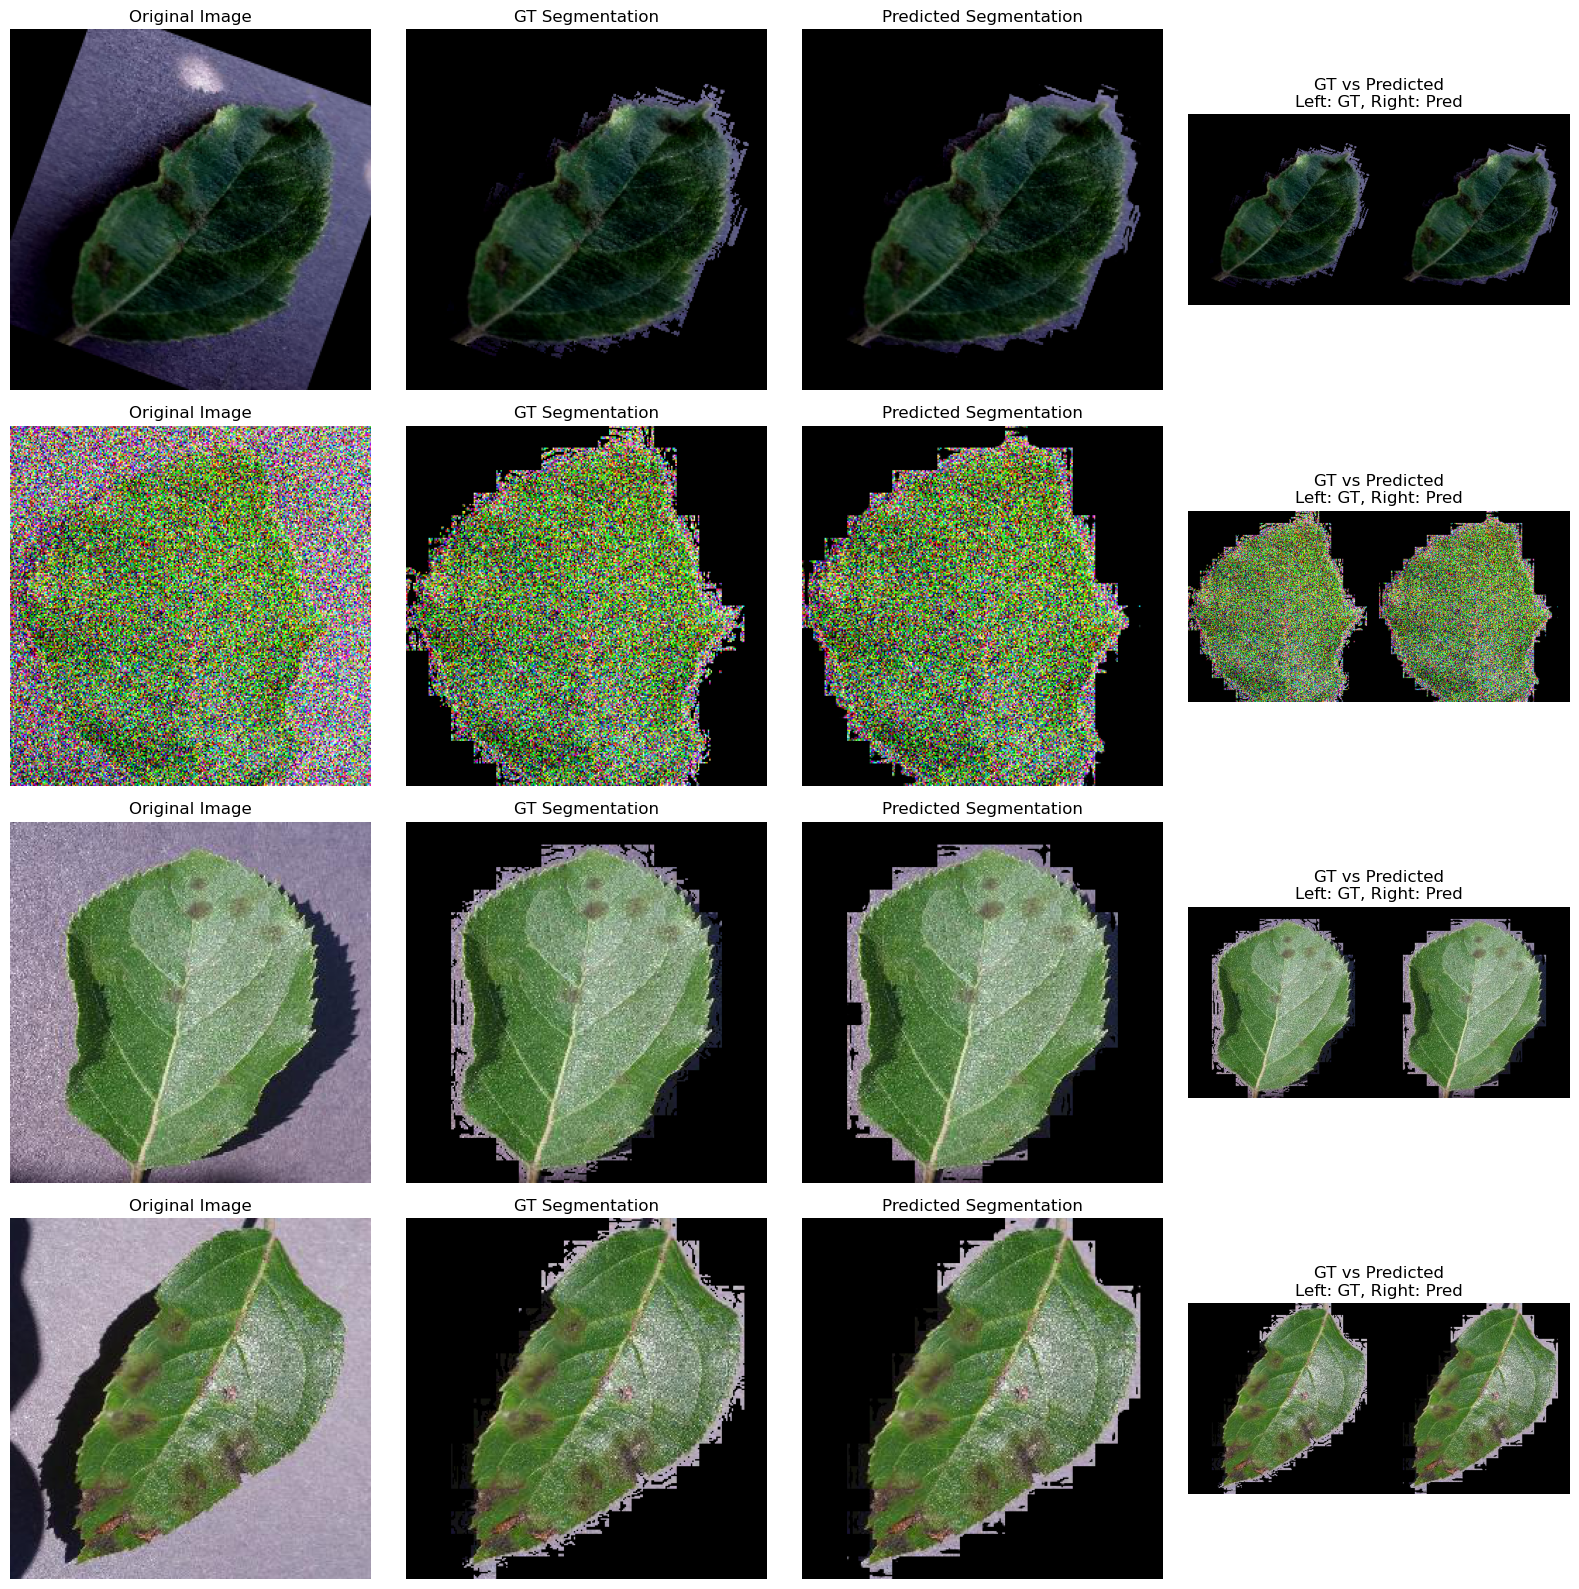

In [ ]:
def test_model(model, test_loader, num_samples=4):
    model.eval()

    with torch.no_grad():
        for images, masks, labels in test_loader:
            # Denormalize
            mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1)
            std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1)
            images_denorm = images * std + mean
            images_denorm = torch.clamp(images_denorm, 0, 1)

            images_gpu = images.to(device)
            outputs = model(images_gpu)

            # Convert to numpy
            images_np = images_denorm.cpu().numpy()
            masks_np = masks.cpu().numpy()
            outputs_np = outputs.cpu().numpy()

            # Plot visualizations
            fig, axes = plt.subplots(num_samples, 4, figsize=(16, num_samples * 4))
            for i in range(num_samples):
                img_rgb = images_np[i].transpose(1, 2, 0)
                gt_mask = masks_np[i].squeeze()
                pred_mask = outputs_np[i].squeeze()
                
                # 1. Original Image
                axes[i, 0].imshow(img_rgb)
                axes[i, 0].set_title(f'Original Image')
                axes[i, 0].axis('off')
                
                # 2. Ground Truth Segmentation
                seg_gt = img_rgb * gt_mask[:, :, np.newaxis]
                axes[i, 1].imshow(seg_gt)
                axes[i, 1].set_title(f'GT Segmentation')
                axes[i, 1].axis('off')

                # 3. Predicted Segmentation  
                seg_pred = img_rgb * pred_mask[:, :, np.newaxis]
                axes[i, 2].imshow(seg_pred)
                axes[i, 2].set_title(f'Predicted Segmentation')
                axes[i, 2].axis('off')

                # 4. Comparison (Side by side)
                comparison = np.hstack([seg_gt, seg_pred])
                axes[i, 3].imshow(comparison)
                axes[i, 3].set_title(f'GT vs Predicted\nLeft: GT, Right: Pred')
                axes[i, 3].axis('off')

            plt.tight_layout()
            plt.show()
            break

test_model(segm_model, test_loader, num_samples=4)

### 3.1.2. Model evaluation metrics and scores

In [22]:
def model_metrics(model, test_loader):
    model.eval()
    total_iou = 0.0
    total_dice = 0.0
    total_precision = 0.0
    total_recall = 0.0
    total_samples = 0

    with torch.no_grad():
        pbar = tqdm.tqdm(test_loader, desc="Calculating Metrics")
        
        for images, masks, labels in pbar:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            pred_masks = (outputs > 0.5).float()

            batch_iou = 0.0
            batch_dice = 0.0
            batch_precision = 0.0
            batch_recall = 0.0
            batch_size = images.size(0)
            
            for i in range(batch_size):
                gt_mask = masks[i].squeeze().cpu().numpy().astype(bool)
                pred_mask = pred_masks[i].squeeze().cpu().numpy().astype(bool)

                # Calculate metrics
                intersection = np.logical_and(gt_mask, pred_mask)
                union = np.logical_or(gt_mask, pred_mask)
                
                tp = np.sum(intersection)  # True Positives
                fp = np.sum(np.logical_and(pred_mask, np.logical_not(gt_mask)))  # False Positives
                fn = np.sum(np.logical_and(gt_mask, np.logical_not(pred_mask)))  # False Negatives
                
                # IoU
                iou = tp / np.sum(union) if np.sum(union) > 0 else 0.0
                
                # Dice
                dice = (2.0 * tp) / (np.sum(gt_mask) + np.sum(pred_mask)) if (np.sum(gt_mask) + np.sum(pred_mask)) > 0 else 0.0
                
                # Precision and Recall
                precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
                recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0

                batch_iou += iou
                batch_dice += dice
                batch_precision += precision
                batch_recall += recall

            total_iou += batch_iou
            total_dice += batch_dice
            total_precision += batch_precision
            total_recall += batch_recall
            total_samples += batch_size
            
            pbar.set_postfix({
                'IoU': f'{batch_iou/batch_size:.3f}',
                'Dice': f'{batch_dice/batch_size:.3f}'
            })

    # Calculate averages
    avg_iou = total_iou / total_samples
    avg_dice = total_dice / total_samples
    avg_precision = total_precision / total_samples
    avg_recall = total_recall / total_samples
    avg_f1 = 2 * (avg_precision * avg_recall) / (avg_precision + avg_recall) if (avg_precision + avg_recall) > 0 else 0.0

    return {
        'IoU': avg_iou,
        'Dice': avg_dice,
        'Precision': avg_precision,
        'Recall': avg_recall,
        'F1-Score': avg_f1
    }

## 3.2. Reload the Segmenation model for future use

In [25]:
# Reload the segmentation model
load_segm_model = Unet(in_channels=3, num_classes=1).to(device)
load_segm_model.load_state_dict(torch.load('G:\Work Projects\AI & ML Projects\Plants-Disease-Detection---Identification\plant_segmentation_model_final.pth'))

<All keys matched successfully>

In [26]:
# Test the model and print metrics
metrics = model_metrics(load_segm_model, test_loader)

print("\n" + "="*50)
print("MODEL PERFORMANCE METRICS")
print("="*50)
for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")
print("="*50)

Calculating Metrics: 100%|██████████| 334/334 [02:45<00:00,  2.02it/s, IoU=0.945, Dice=0.971]


MODEL PERFORMANCE METRICS
IoU: 0.9464
Dice: 0.9717
Precision: 0.9715
Recall: 0.9733
F1-Score: 0.9724


# 4. Building the classification Model (ResNet50)
- We're going to use a pretrained model (ResNet50) for the classification task.
- We will retrain the last few layers to learn on our dataset.

If the model did not perform, we will change to a more suitable/advanced model.

In [28]:
import torchvision.models as models

## 4.1. Importing ResNet18

In [29]:
# Create Resnet50
cls_model = models.resnet50(pretrained=True)

# Freeze layers
for param in cls_model.parameters():
    param.requires_grad = False

num_classes = len(train_dataset.class_to_idx)

# Modify the last classifier layer
cls_model.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(cls_model.fc.in_features, 512),
    nn.ReLU(inplace=True),
    nn.Dropout(0.3),
    nn.Linear(512, num_classes)
)

# Print results
print(f"Created Resnet50 with {num_classes} classes.")
print(f"Class mapping: {train_dataset.class_to_idx}")

c:\Users\basel\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\basel\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\basel/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:32<00:00, 3.16MB/s]


Created Resnet50 with 38 classes.
Class mapping: {'Apple___Apple_scab': 0, 'Apple___Black_rot': 1, 'Apple___Cedar_apple_rust': 2, 'Apple___healthy': 3, 'Blueberry___healthy': 4, 'Cherry_(including_sour)___healthy': 5, 'Cherry_(including_sour)___Powdery_mildew': 6, 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot': 7, 'Corn_(maize)___Common_rust_': 8, 'Corn_(maize)___healthy': 9, 'Corn_(maize)___Northern_Leaf_Blight': 10, 'Grape___Black_rot': 11, 'Grape___Esca_(Black_Measles)': 12, 'Grape___healthy': 13, 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)': 14, 'Orange___Haunglongbing_(Citrus_greening)': 15, 'Peach___Bacterial_spot': 16, 'Peach___healthy': 17, 'Pepper,_bell___Bacterial_spot': 18, 'Pepper,_bell___healthy': 19, 'Potato___Early_blight': 20, 'Potato___healthy': 21, 'Potato___Late_blight': 22, 'Raspberry___healthy': 23, 'Soybean___healthy': 24, 'Squash___Powdery_mildew': 25, 'Strawberry___healthy': 26, 'Strawberry___Leaf_scorch': 27, 'Tomato___Bacterial_spot': 28, 'Tomato___Early

In [30]:
# Print model Summary
print("Model Summary:")
print(summary(cls_model, (3, 224, 224)))
print("="*50)

Model Summary:
Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 112, 112]        (9,408)
├─BatchNorm2d: 1-2                       [-1, 64, 112, 112]        (128)
├─ReLU: 1-3                              [-1, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [-1, 64, 56, 56]          --
├─Sequential: 1-5                        [-1, 256, 56, 56]         --
|    └─Bottleneck: 2-1                   [-1, 256, 56, 56]         --
|    |    └─Conv2d: 3-1                  [-1, 64, 56, 56]          (4,096)
|    |    └─BatchNorm2d: 3-2             [-1, 64, 56, 56]          (128)
|    |    └─ReLU: 3-3                    [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-4                  [-1, 64, 56, 56]          (36,864)
|    |    └─BatchNorm2d: 3-5             [-1, 64, 56, 56]          (128)
|    |    └─ReLU: 3-6                    [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-7                  [-1,

## 4.2. Training the classification model

In [ ]:
# train function for classifier model
def train_cls(model_check_point, model, train_loader, val_loader, epochs=20, lr=0.001, save_path = None):
    """
    Function to train the classification model.
    inputs:
        1. model: The model to be trained.
        2. train_loader: The training data loader.
        3. val_loader: The validation data loader.
        4. epochs: The number of epochs to train for.
        5. lr: The learning rate.
        6. save_path: The path to save the model.
    """
    # Check for model checkpoint
    if model_check_point and os.path.exists(model_check_point):
        model.load_state_dict(torch.load(model_check_point))
        print(f"Loaded model checkpoint from {model_check_point}")
    else:
        print("No model checkpoint found. Training from scratch.")
        
    # Loss and Optimizer and scheduler
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    scehduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

    # losses
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    # Training phase
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        # Progress bar for training
        train_pbar = tqdm.tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs} [Train]')

        for images, masks, labels in train_pbar:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_correct += (outputs.argmax(dim=1) == labels).sum().item()
            train_total += labels.size(0)

            train_pbar.set_postfix({'Loss': f'{loss.item():.4f}', 'Accuracy': f'{(train_correct/train_total)*100:.2f}%'})
        
        # Calculate Average Metrics
        avg_train_loss = train_loss / len(train_loader)
        train_accuracy = 100* (train_correct / train_total)
        train_losses = np.append(train_losses, avg_train_loss)
        train_accuracies = np.append(train_accuracies, train_accuracy)

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        # Validation Progress bar
        val_pbar = tqdm.tqdm(val_loader, desc=f'Epoch {epoch+1}/{epochs} [Val]')

        with torch.no_grad():
            for images, masks, labels in val_pbar:
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_correct += (outputs.argmax(dim=1) == labels).sum().item()
                val_total += labels.size(0)

                val_pbar.set_postfix({'Loss': f'{loss.item():.4f}', 'Accuracy': f'{(val_correct/val_total)*100:.2f}%'})
        
        # Calculate Average Metrics
        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = 100* (val_correct / val_total)
        val_losses = np.append(val_losses, avg_val_loss)
        val_accuracies = np.append(val_accuracies, val_accuracy)

        # Update learning rate
        scehduler.step(avg_val_loss)
        current_lr = optimizer.param_groups[0]['lr']

        # Printing information
        print(f"Epoch: [{epoch+1}/{epochs}]")
        print(f"Training Loss: {avg_train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%")
        print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

        # Save model
        if epoch == 0 or val_accuracy > max(val_accuracies[:-1]):
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss,
                'accuracy': val_accuracy
            }, f'{save_path}_final.pth')

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss', marker='o')
    plt.plot(val_losses, label='Validation Loss', marker='s')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training History')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.plot(train_accuracies, label='Training Accuracy', marker='o')
    plt.plot(val_accuracies, label='Validation Accuracy', marker='s')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy History')
    plt.legend()
    plt.grid(True)
    plt.show()

    return model, train_losses, val_losses, train_accuracies, val_accuracies

In [ ]:
# Train the Classifier
classifier_model, train_losses, val_losses, train_accuracies, val_accuracies = train_cls(model_check_point='plant_classification_model.pth', cls_model, train_loader, val_loader, epochs=5, lr=0.0001, save_path='plant_classification_model')

TypeError: train_cls() got multiple values for argument 'epochs'

## 